# <center> Data analysis

In [2]:
import pandas as pd
import numpy as np
import os.path
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import pdist,squareform
import warnings
warnings.filterwarnings('ignore')

base_path = '../dataset'
original_data = os.path.join(base_path, 'original_data')

## 1. Read data

#### Items data

In [6]:
candidate_items=pd.read_csv(os.path.join(original_data, "candidate_items.csv"))
print(candidate_items.head())
print(candidate_items.shape)

item_features=pd.read_csv(os.path.join(original_data,"item_features.csv"))
print(item_features.head())
print(item_features.shape)

   item_id
0        4
1        8
2        9
3       19
4       20
(4990, 1)
   item_id  feature_category_id  feature_value_id
0        2                   56               365
1        2                   62               801
2        2                   68               351
3        2                   33               802
4        2                   72                75
(471751, 3)


#### Sessions

In [7]:
# read sessions
train_sessions=pd.read_csv(os.path.join(original_data,"train_sessions.csv"), 
                           parse_dates=['date'], infer_datetime_format=True, header=0)
train_sessions["is_train"] = 1
test_leaderboard_sessions=pd.read_csv(os.path.join(original_data,"test_leaderboard_sessions.csv"), 
                                      parse_dates=['date'], infer_datetime_format=True, header=0)
test_final_sessions=pd.read_csv(os.path.join(original_data,"test_final_sessions.csv"), 
                                parse_dates=['date'], infer_datetime_format=True, header=0)
sessions = pd.concat([train_sessions, test_leaderboard_sessions, test_final_sessions])

# Remove the miliseconds to avoid format compitabilities
sessions["date"] = [str(x).split(".")[0] for x in sessions["date"]]
sessions["date"] = pd.to_datetime(sessions["date"], format='%Y-%m-%d %H:%M:%S')
sessions = sessions.rename(columns={"date": "datetime"})

sessions["purchase"] = 0

print(sessions.head())
print(sessions.shape)

   session_id  item_id            datetime  is_train  purchase
0           3     9655 2020-12-18 21:25:00       1.0         0
1           3     9655 2020-12-18 21:19:48       1.0         0
2          13    15654 2020-03-13 19:35:27       1.0         0
3          18    18316 2020-08-26 19:18:30       1.0         0
4          18     2507 2020-08-26 19:16:31       1.0         0
(5199312, 5)


#### Purchases

In [8]:
train_purchases=pd.read_csv(
    os.path.join(original_data,"train_purchases.csv"),parse_dates=['date'], infer_datetime_format=True,header=0)
        
# Remove the miliseconds to avoid format compitabilities
train_purchases["date"] = [str(x).split(".")[0] for x in train_purchases["date"]]
train_purchases["date"] = pd.to_datetime(train_purchases["date"], format='%Y-%m-%d %H:%M:%S')
train_purchases = train_purchases.rename(columns={"date": "datetime"})

train_purchases["is_train"] = 1
train_purchases["purchase"] = 1

print(train_purchases.head())
print(train_purchases.shape)

   session_id  item_id            datetime  is_train  purchase
0           3    15085 2020-12-18 21:26:47         1         1
1          13    18626 2020-03-13 19:36:15         1         1
2          18    24911 2020-08-26 19:20:32         1         1
3          19    12534 2020-11-02 17:16:45         1         1
4          24    13226 2020-02-26 18:27:44         1         1
(1000000, 5)


#### Full fataset

In [9]:
full = pd.concat([sessions, train_purchases])
full = pd.merge(full, item_features, on="item_id")
full = full.sort_values("datetime")

print(full.head())
print(full.shape)

          session_id  item_id            datetime  is_train  purchase  \
86869010     3747794    11234 2020-01-01 00:00:01       1.0         0   
86869008     3747794    11234 2020-01-01 00:00:01       1.0         0   
86869009     3747794    11234 2020-01-01 00:00:01       1.0         0   
86869011     3747794    11234 2020-01-01 00:00:01       1.0         0   
86869012     3747794    11234 2020-01-01 00:00:01       1.0         0   

          feature_category_id  feature_value_id  
86869010                   62                15  
86869008                   30               847  
86869009                   43               788  
86869011                   72                75  
86869012                   69               805  
(134304918, 7)


## 2. Basic stats

In [10]:
df = full[full["is_train"] == 1]
df = df.groupby("session_id").agg({"item_id": ["count", "nunique"], "datetime": ["min", "max"]})
df.columns = ['_'.join(col) for col in df.columns]

# session size
# sns.histplot(df["item_id_count"])

# session duration
df["duration_in_minutes"] = (df["datetime_max"] - df["datetime_min"]).dt.seconds / 60

# session repeating items
df["pct_uniqueness"] = df["item_id_nunique"] / df["item_id_count"]

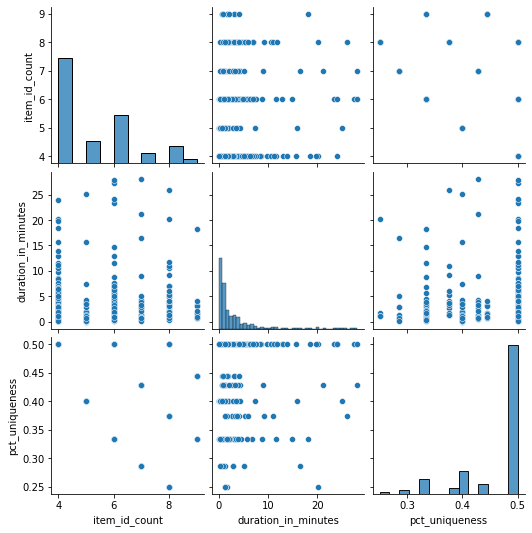

In [11]:
clean_df = df[(df["item_id_count"] < 10) & (df["duration_in_minutes"] < 30)]
sns.pairplot(clean_df[["item_id_count", "duration_in_minutes", "pct_uniqueness"]])

In [12]:
# new items - not in train but in test
train_items = full[full["is_train"] == 1]["item_id"].unique()
new_items = full[(full["is_train"] == 0) & (~full["item_id"].isin(train_items))]
print("new items:", len(new_items))

# candidate but not seen
unused_items = candidate_items[~candidate_items["item_id"].isin(full["item_id"].unique())]
print("unused items:", len(unused_items))

new items: 0
unused items: 4


## 3. Items popularity

In [13]:
df = full[full["is_train"] == 1]
df = df.groupby("item_id").agg(
    {"feature_category_id": ["nunique", "count"], "session_id": "nunique", "purchase": "sum"})
df.columns = ['_'.join(col) for col in df.columns]
df.columns = ["n_categories", "n_values", "views", "purchases"]
df = df.reset_index()

In [14]:
# top k popular items (for purchase)
k = 500

top = df.sort_values("purchases", ascending=False).head(k)
low = df[df["purchases"] > 0].sort_values("purchases", ascending=True).head(k)
no_purchases = df[df["purchases"] == 0]

df["popularity"] = np.where(df["item_id"].isin(top["item_id"]), "high", "medium")
df["popularity"] = np.where(df["item_id"].isin(low["item_id"]), "low", df["popularity"])
df["popularity"] = np.where(df["item_id"].isin(no_purchases["item_id"]), "no_purchases", df["popularity"])

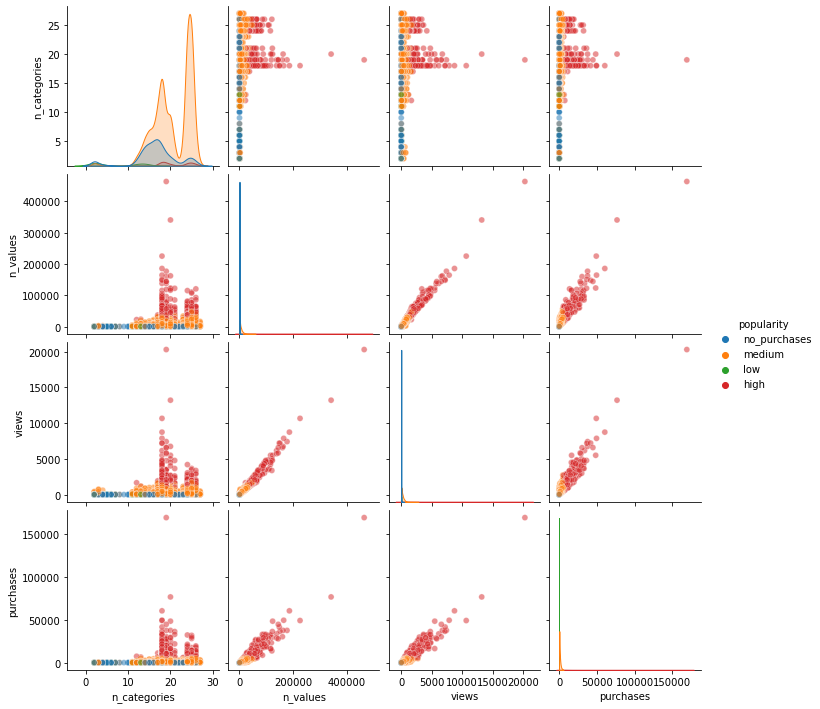

In [15]:
# do items with more categories/values have more purchases/views?
sns.pairplot(df.drop("item_id", axis=1), hue="popularity", plot_kws=dict(alpha=0.5))

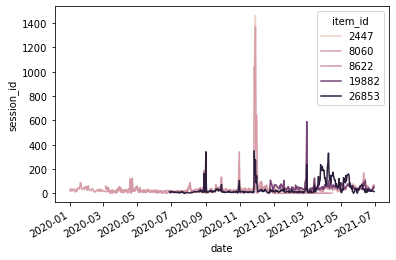

In [16]:
# popular items over time
m = 5
top_m = top.head(m)["item_id"]
df = full[(full["item_id"].isin(top_m))]

df["date"] = df["datetime"].dt.date
df = df.groupby(["item_id", "date"]).agg({"session_id": "nunique"}).reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=df, x="date", y="session_id", hue="item_id")
fig.autofmt_xdate()
plt.show()

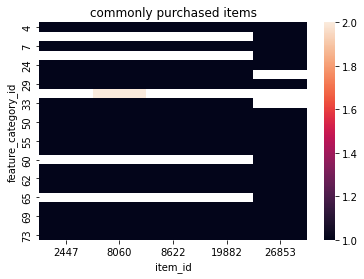

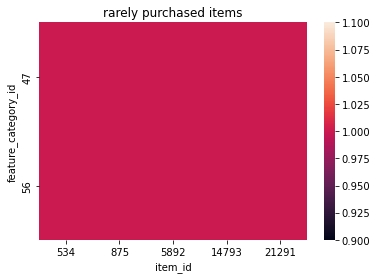

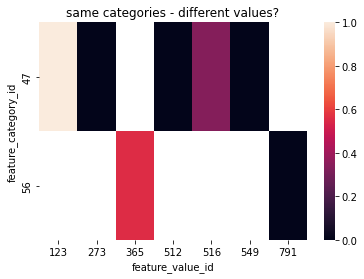

In [17]:
# drill down on top/rare items - spesific categories?
m = 5
top_m, low_m = top.head(m)["item_id"], low.head(m)["item_id"]
df = full[(full["item_id"].isin(top_m)) | (full["item_id"].isin(low_m))
           ].drop_duplicates(["item_id", "feature_category_id", "feature_value_id"])
df["group"] = np.where(df["item_id"].isin(top_m), "common", "rare")

for group_name in df["group"].unique():
    tmp = df[df["group"] == group_name]
    matrix = pd.crosstab(index=tmp['feature_category_id'], columns=tmp['item_id'], 
                         values=tmp["feature_value_id"], aggfunc="count", normalize=False)
    sns.heatmap(matrix) 
    plt.title(f"{group_name}ly purchased items")
    plt.show()
    
# same categories - different values?
top_categories = df[df["group"] == "common"]["feature_category_id"]
low_categories = df[df["group"] == "rare"]["feature_category_id"]
shared_categories = list(set(top_categories) & set(low_categories))
df = df[df["feature_category_id"].isin(shared_categories)]
df["popular"] = np.where(df["group"] == "common", 1, 0)

matrix = pd.crosstab(index=df['feature_category_id'], columns=df['feature_value_id'], 
                     values=df["popular"], aggfunc="mean", normalize=False)
sns.heatmap(matrix) 
plt.title("same categories - different values?")
plt.show()

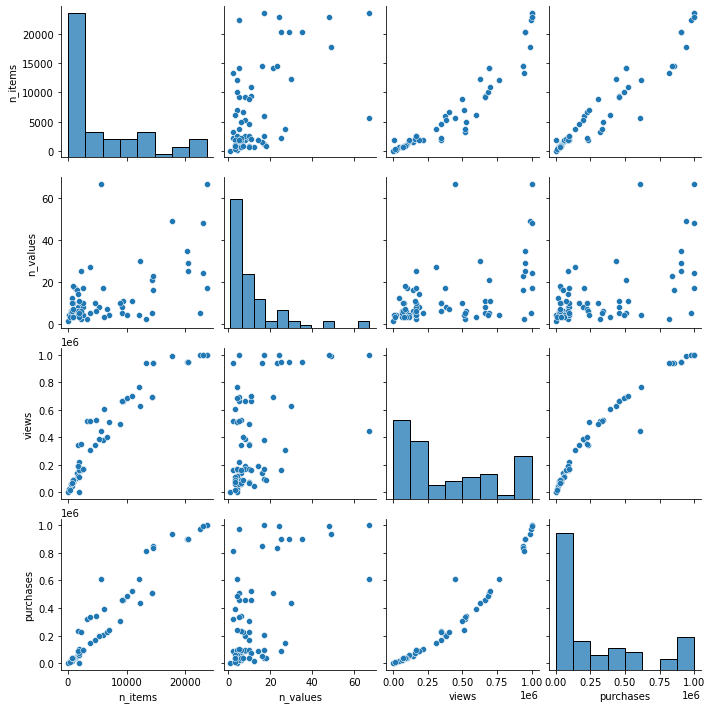

In [18]:
# top categories - and category impact on view/purchase

df = full[full["is_train"] == 1]
df = df.groupby("feature_category_id").agg(
    {"item_id": "nunique", "feature_value_id": "nunique", "session_id": "nunique", "purchase": "sum"})
df.columns = ['_'.join(col) for col in df.columns]
df.columns = ["n_items", "n_values", "views", "purchases"]

sns.pairplot(df)
plt.show()
# top k common categories among items (or top viewed/purchased/various)

## 4. Items relationships

In [19]:
# similarity matrix - by categories values
df = full.drop_duplicates(["item_id", "feature_value_id"])

df = df.pivot(index='item_id', columns='feature_value_id', values="feature_category_id").notnull()

sim_matrix = squareform(pdist(df, metric='hamming'))
sim_matrix = pd.DataFrame(sim_matrix, index=df.index, columns=df.index)
sim_matrix

item_id,2,3,4,7,8,9,10,11,13,14,...,28133,28134,28135,28137,28138,28139,28140,28141,28142,28143
item_id,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.035996,0.033746,0.028121,0.031496,0.039370,0.023622,0.025872,0.021372,0.028121,...,0.023622,0.017998,0.031496,0.021372,0.033746,0.035996,0.029246,0.035996,0.026997,0.028121
3,0.035996,0.000000,0.024747,0.032621,0.020247,0.023622,0.037120,0.034871,0.030371,0.039370,...,0.039370,0.038245,0.033746,0.032621,0.026997,0.031496,0.038245,0.024747,0.042745,0.032621
4,0.033746,0.024747,0.000000,0.037120,0.017998,0.025872,0.039370,0.034871,0.032621,0.043870,...,0.034871,0.038245,0.035996,0.030371,0.026997,0.029246,0.040495,0.029246,0.042745,0.039370
7,0.028121,0.032621,0.037120,0.000000,0.034871,0.038245,0.026997,0.031496,0.031496,0.031496,...,0.035996,0.028121,0.034871,0.031496,0.039370,0.037120,0.034871,0.034871,0.028121,0.029246
8,0.031496,0.020247,0.017998,0.034871,0.000000,0.023622,0.037120,0.032621,0.032621,0.041620,...,0.034871,0.035996,0.033746,0.030371,0.022497,0.026997,0.038245,0.031496,0.042745,0.032621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,0.035996,0.031496,0.029246,0.037120,0.026997,0.028121,0.034871,0.032621,0.028121,0.043870,...,0.037120,0.040495,0.031496,0.028121,0.024747,0.000000,0.038245,0.035996,0.042745,0.034871
28140,0.029246,0.038245,0.040495,0.034871,0.038245,0.041620,0.032621,0.037120,0.028121,0.037120,...,0.037120,0.035996,0.038245,0.030371,0.038245,0.038245,0.000000,0.035996,0.038245,0.032621
28141,0.035996,0.024747,0.029246,0.034871,0.031496,0.034871,0.037120,0.037120,0.032621,0.039370,...,0.041620,0.040495,0.040495,0.034871,0.031496,0.035996,0.035996,0.000000,0.042745,0.034871


In [20]:
# most simmilar items

min_distance = sim_matrix[sim_matrix > 0].min().min()
top_similar = sim_matrix[sim_matrix.isin([min_distance])].stack() 

print(f"top similar items:\n{top_similar}")

top similar items:
item_id  item_id
24       4304       0.001125
42       687        0.001125
         2990       0.001125
         4232       0.001125
         4397       0.001125
                      ...   
28036    20900      0.001125
         24955      0.001125
         27612      0.001125
28105    702        0.001125
28120    22742      0.001125
Length: 10650, dtype: float64


In [21]:
selected_similar_pair = [27021, 27400]
print('selected similar items pair:', selected_similar_pair)

selected similar items pair: [27021, 27400]


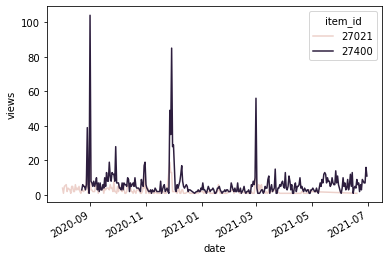

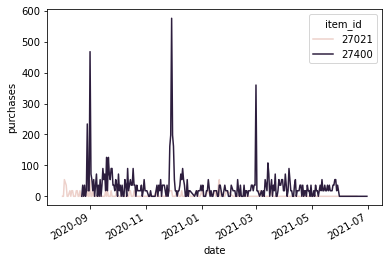

In [22]:
# most similar items - are they similar also in purchases and views along time?

df = full[(full["item_id"].isin(selected_similar_pair))]
df["date"] = df["datetime"].dt.date
df = df.groupby(["item_id", "date"]).agg({"session_id": "nunique", "purchase": "sum"})
df.columns = ['_'.join(col) for col in df.columns]
df.columns = ["views", "purchases"]
df = df.sort_values("date").reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=df, x="date", y="views", hue="item_id")
fig.autofmt_xdate()
plt.show()

fig, ax = plt.subplots()
sns.lineplot(data=df, x="date", y="purchases", hue="item_id")
fig.autofmt_xdate()
plt.show()

In [23]:
# most simiar items - do they appear in same sessions?

df = full[(full["item_id"].isin(selected_similar_pair))].drop_duplicates(["item_id", "session_id"])

df = df.pivot(index='item_id', columns='session_id', values="feature_category_id").notnull()
df = df.T

common_sessions = len(df[df[selected_similar_pair[0]] == df[selected_similar_pair[1]]])
print(f"common sessions between the items: {common_sessions} out of {len(df)}")

common sessions between the items: 3 out of 2514


## 5. Seasonality and trends

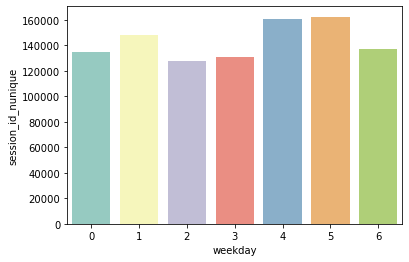

In [24]:
# popular seasons

df = full[full["is_train"] == 1]
df["weekday"] = df["datetime"].dt.weekday
df["weekend"] = np.where(df["weekday"].isin([5, 6]), 1, 0)

df = df.groupby("weekday").agg({"item_id": ["nunique"], "session_id": ["nunique"]})
df.columns = ['_'.join(col) for col in df.columns]

# number of sessions along the week
sns.barplot(df.reset_index(), x="weekday", y="session_id_nunique", palette="Set3")
plt.show()

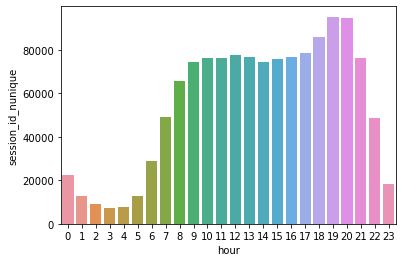

In [25]:
# popular hours

df = full[full["is_train"] == 1]
df["hour"] = df["datetime"].dt.hour

df = df.groupby("hour").agg({"item_id": ["nunique"], "session_id": ["nunique"]})
df.columns = ['_'.join(col) for col in df.columns]

# number of sessions along the day
sns.barplot(df.reset_index(), x="hour", y="session_id_nunique")
plt.show()

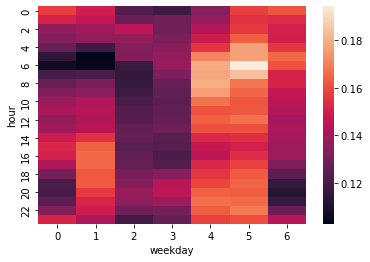

In [26]:
# relations between day and hour

df = full[full["is_train"] == 1]
df["weekday"] = df["datetime"].dt.weekday
df["hour"] = df["datetime"].dt.hour

df = df.groupby(["hour", "weekday"]).agg({"item_id": ["nunique"], "session_id": ["nunique"]})
df.columns = ['_'.join(col) for col in df.columns]
df = df.reset_index()

matrix = pd.crosstab(index=df['hour'], columns=df['weekday'], values=df['session_id_nunique'], aggfunc="sum",
                     normalize='index')
sns.heatmap(matrix) 
plt.show()

           date  item_id_nunique  session_id_nunique
243  2020-09-01             4362               11450
330  2020-11-27             5253               17255
331  2020-11-28             4790               11114
332  2020-11-29             5035               15961
422  2021-03-01             3946               12754


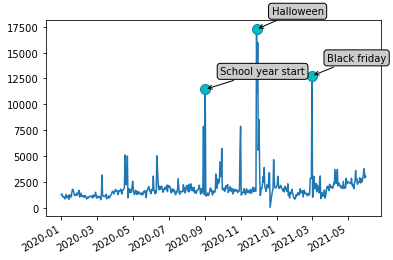

In [27]:
# number of sessions over time

df = full[full["is_train"] == 1]
df["date"] = df["datetime"].dt.date

df = df.groupby("date").agg({"item_id": ["nunique"], "session_id": ["nunique"]})
df.columns = ['_'.join(col) for col in df.columns]

# peaks
threshold = 10000
peaks = df.reset_index()
peaks = peaks[peaks["session_id_nunique"] > threshold].sort_values("date")
print(peaks.head())

# plot

x=df.index
y=df["session_id_nunique"]
holidays = {243: "School year start", 330: "Halloween", 422: "Black friday"}

fig, ax = plt.subplots()

ax.plot_date(x, y, linestyle='-',
            marker="o", markevery=list(holidays.keys()), ms=10, mfc='c')

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
for h, h_name in holidays.items():
    md = (mdates.date2num(x[h]), y[h])
    ax.annotate(h_name, xy=md, xytext=(15, 15), #ha="center", va="top", 
                textcoords='offset points', bbox=bbox_args, arrowprops=arrow_args)

fig.autofmt_xdate()
plt.show()

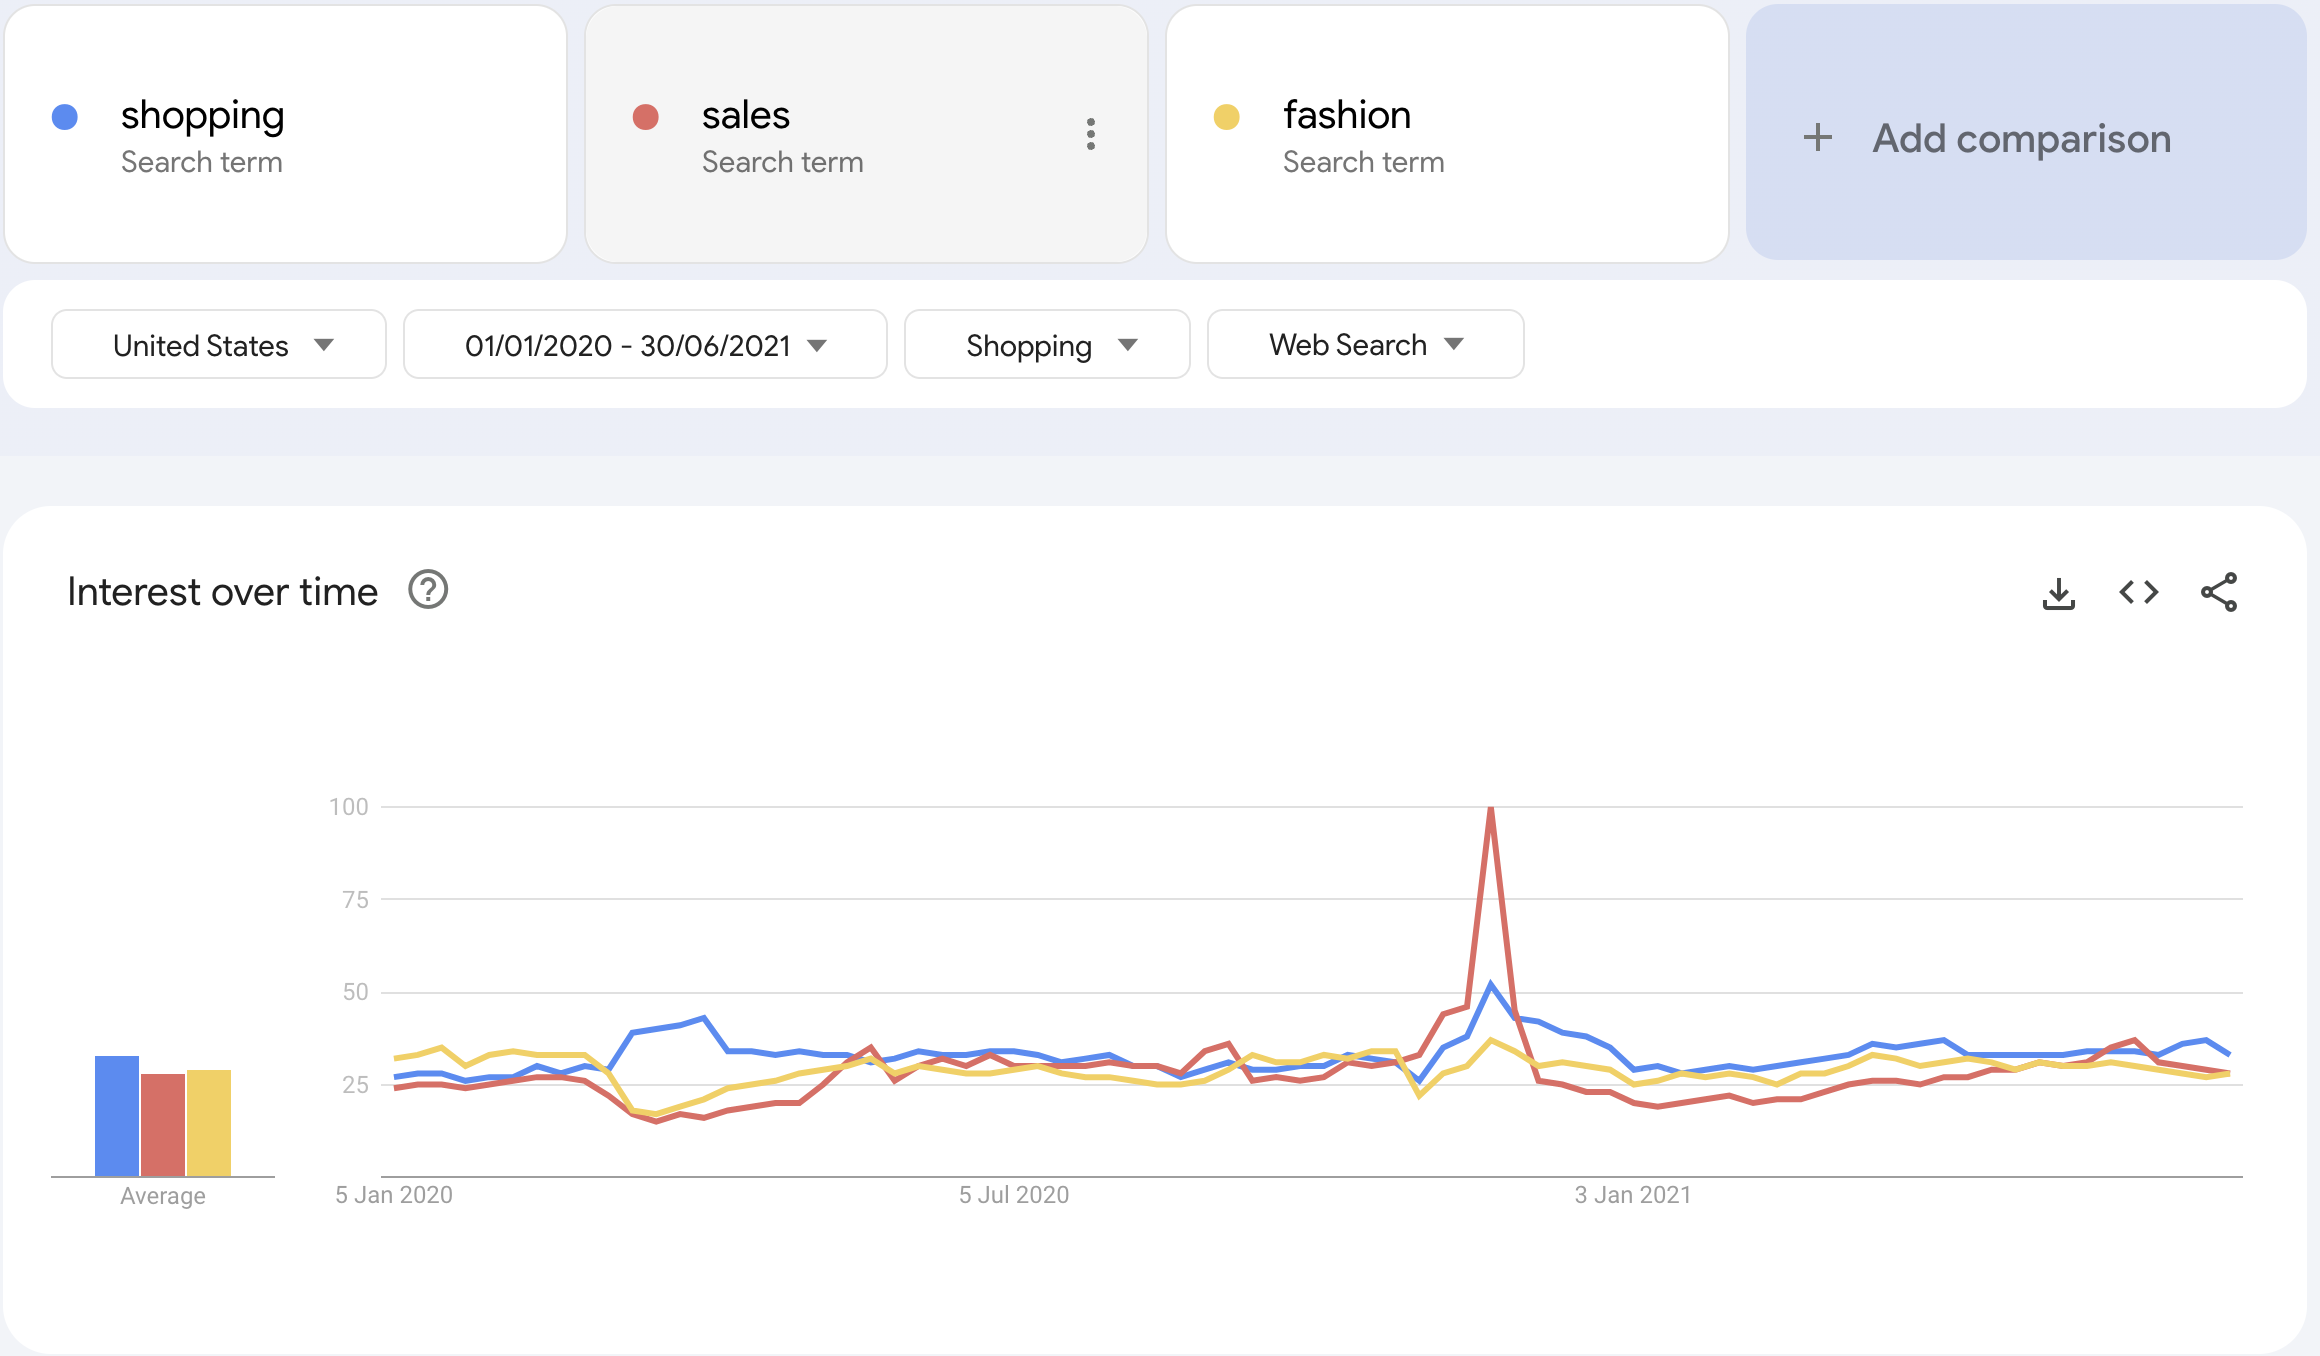

In [28]:
# google trends
from IPython.display import Image
path = 'google_trends.png'
Image(filename=path)